In [4]:
#!pip3 install --upgrade torch torchvision
#!pip install imageio-ffmpeg
#Refernce to these code is: https://github.com/deep-learning-with-pytorch/dlwpt-code

In [2]:
import numpy as np
import imageio
import torch
import csv
import os
from scipy import signal
import scipy.io.wavfile as wavfile
%matplotlib inline
import matplotlib.pyplot as plt

# Chapter 4: Real-world data representation using tensors #
- Representing real world data as PyTorch tensors
- Working with a range of data types
- Loading data from a file
- Converting data to tensors
- Shaping tensors so they can be used as inputs for neural network models

## Images ##

Tensors are building blocks in pytorch. 
Any library that outputs a NumPy array would be sufficianet to obtain a pytorch tensor. 

Images are represented as a collection of scalars arranged in a regular grid 
with a height and width in pixels. we might have a single scalar per pixel or
multiple scalars per pixel that represent a different color, or different feature like depth. 

Lets explore one image preparation for modeling:

In [18]:
img_arr=imageio.imread("./image-dog/bobby.jpg")

In [19]:
img_arr.shape

(720, 1280, 3)

Above shows two spatial dimensions, width and height; and channel. H*W*C
PyTorch modules dealing with image data require tensors to be laid out as C × H × W:
channels, height, and width C*H*W

In [23]:
img=torch.from_numpy(img_arr)
out=img.permute(2,0,1)
out.shape

torch.Size([3, 720, 1280])

#### Batch of Images ####

We store the images in a batch along the first dimension to obtain an
N(batches) × C(channel) × H(height) × W(width) tensor.
When we have more than one image, it would be wise to use batching in order to save time in computation.

Lets explore more than one image preparation:

In [11]:
cat_dir='./image-cats/'

In [14]:
#Initialize batches
batch_size=3
batch=torch.zeros(batch_size,3,256,256,dtype=torch.uint8)
filenames = [name for name in os.listdir(cat_dir) if os.path.splitext(name)[-1] == '.png']

for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(cat_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    #keep first three channel
    img_t = img_t[:3]
    batch[i] = img_t

In [28]:
#normalize data along channels
n_channels = batch.shape[1]

batch = batch.float()
batch /= 255.0

for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std
    
batch[1:2,1,1,1:5]

tensor([[0.4822, 0.3684, 0.3684, 0.5391]])

### 3D Images ###

Here we have images that has mroe than 2 dimension. There is no fundamental difference between a tensor storing volumetric(3D images)
data versus image data other than it adds one more dimension with depth. 

We just have an extra dimension, depth, after the channel
dimension, leading to a 5D tensor of shape N × C × D × H × W.

We need to make room for channel by using unsqueeze:

In [150]:
vol_dir="./volumetric-dicom/"

Reading DICOM (examining files): 1/99 files (1.0%82/99 files (82.8%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 47/99  (47.599/99  (100.0%)
(99, 512, 512)


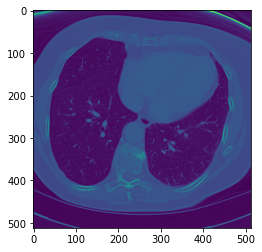

In [151]:
vol_arr=imageio.volread(vol_dir,'DICOM')
print(vol_arr.shape)
plt.imshow(vol_arr[61])

In [152]:
# we need to make a room for channel dimension using unsqueeze 

vol=torch.from_numpy(vol_arr).float()
vol=torch.unsqueeze(vol,0)
vol.shape

torch.Size([1, 99, 512, 512])

## CSV file ##

Here we prepare Tabular data for deep learning model as follows: 
We start by loading the file, encoding last column which is target columns. The actual target are bad wines that their quality are bad, and predicted target are the wines that total sulfur dioxide is more than defined threshold
Here we use navie modeling and output accuracy metrics results.
    

In [153]:
wine_dir="./tabular-wine/winequality-white.csv"

In [154]:
wine_numpy=np.loadtxt(wine_dir,dtype=np.float32,delimiter=";",skiprows=1)
col_list=next(csv.reader(open(wine_dir),delimiter=';'))
col_list

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [160]:
#differentiate data and target variables
wineq = torch.from_numpy(wine_numpy)
data = wineq[:, :-1]
target = wineq[:, -1].long()

target_onehot = torch.zeros(target.shape[0], 10)
#target_onehot has two dimensions (4,898 × 10), along first dimension,we got the column of indices to scatter 

target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [157]:
#Normalize data
data_mean = torch.mean(data, dim=0)
data_var = torch.var(data, dim=0)
data_normalized = (data - data_mean) / torch.sqrt(data_var)

In [158]:
#get the average of each range of target 
bad_data = data[target <= 3]
mid_data = data[(target > 3) & (target < 7)]
good_data = data[target >= 7]

bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)
for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
    print('{:2} {:20} {:6.2f} {:6.2f} {:6.2f}'.format(i, *args))

 0 fixed acidity          7.60   6.89   6.73
 1 volatile acidity       0.33   0.28   0.27
 2 citric acid            0.34   0.34   0.33
 3 residual sugar         6.39   6.71   5.26
 4 chlorides              0.05   0.05   0.04
 5 free sulfur dioxide   53.33  35.42  34.55
 6 total sulfur dioxide 170.60 141.83 125.25
 7 density                0.99   0.99   0.99
 8 pH                     3.19   3.18   3.22
 9 sulphates              0.47   0.49   0.50
10 alcohol               10.34  10.26  11.42


In [165]:
#prediction of bad wines using threshold
total_sulfur_threshold = 141.83
total_sulfur_data = data[:,6]
predicted_indexes = torch.lt(total_sulfur_data, total_sulfur_threshold)

#actual values of bad wines
actual_indexes = target > 5
n_matches = torch.sum(actual_indexes & predicted_indexes).item()
n_predicted = torch.sum(predicted_indexes).item()
n_actual = torch.sum(actual_indexes).item()

print(n_matches)
print("precision is" , n_matches / n_predicted) 
print("recall is " , n_matches / n_actual)

2018
precision is 0.74000733406674
recall is  0.6193984039287906


We got around 2,000 wines right! Since we predicted 2,700 wines, this gives us a 74%
chance that if we predict a wine to be high quality, it actually is. Unfortunately, there
are 3,200 good wines, and we only identified 61% of them. Well, we got what we
signed up for; that’s barely better than random!

## Time Series ## 

We can break up time sereis into wider observation. 
Our time series dataset would be a tensor of dimension 3 
and shape N(number of samples) × C(sequence of length) × L(length). C would be columns and L would be 24 like following example:

In [ ]:
bikes_numpy = np.loadtxt("./bike-sharing-dataset/hour-fixed.csv",
dtype=np.float32, delimiter=",", skiprows=1,converters={1: lambda x: float(x[8:10])})

In [137]:
#bikes.shape[1] is 17, the number of columns in the bikes tensor. -1 is a placeholder for “however many indexes are
#left, given the other dimensions and the original number of elements
bikes = torch.from_numpy(bikes_numpy)
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
daily_bikes = daily_bikes.transpose(1, 2)

#lets use one hot encoder to treat "weather situation” variable.
daily_weather_onehot = torch.zeros(daily_bikes.shape[0], 4, daily_bikes.shape[2])
daily_weather_onehot.scatter_(1, daily_bikes[:,9,:].long().unsqueeze(1) - 1, 1.0)
daily_bikes = torch.cat((daily_bikes, daily_weather_onehot), dim=1)

In [ ]:
#normalize data
temp = daily_bikes[:, 10, :]
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - torch.mean(temp))/ torch.std(temp))

## Text ##

We start by parsing the text and provide one-hot encoding for each of them.
Each character gets represented by a vector of length equal to the number of different characters in the encoding.
Since a vocabulary has many words, this will produce very wide encoded vectors,which may not be practical. 

There is an efficient way to represent text at the word level, using embeddings. word 
embedding takes context into account and gives word with similar meaning or influence in a 
sentence similar value for a specific feature.


In [ ]:
with open("./jane-austen/1342-0.txt",encoding='utf8') as f:
    text=f.read()

In [139]:
lines=text.split('\n')
line=lines[200]

letter_t=torch.zeros(len(line),128)

for i, letter in enumerate(line.lower().strip()):
    letter_index = ord(letter) if ord(letter) < 128 else 0
    letter_t[i][letter_index] = 1

def clean_words(input_str):
    punctuation = '.,;:"!?”“_-'
    word_list = input_str.lower().replace('\n',' ').split()
    word_list = [word.strip(punctuation) for word in word_list]
    return word_list

words_in_line = clean_words(line)

word_list=sorted(set(clean_words(text)))
word2index_dict={word: i for (i,word) in enumerate (word_list)}

word_t = torch.zeros(len(words_in_line),len(word2index_dict))

for i,word in enumerate(words_in_line):
    word_index=word2index_dict[word]
    word_t[i][word_index]=1
    print('{:2} {:4} {}'.format(i,word_index,word))

 0 3394 impossible
 1 4305 mr
 2  813 bennet
 3 3394 impossible
 4 7078 when
 5 3315 i
 6  415 am
 7 4436 not
 8  239 acquainted
 9 7148 with
10 3215 him


## Video ##

Video data can be seen as equivalent to volumetric data, with depth replaced by the time dimension.

The result is again a 5D tensor with shape N x C x T x H x W. This is similar to 3D images dataset preparation. 
The only difference is that instead of D (depth) we do have T(time)

In [13]:
reader = imageio.get_reader('./video-cockatoo/cockatoo.mp4')

In [16]:
meta = reader.get_meta_data()
meta

{'plugin': 'ffmpeg',
 'nframes': inf,
 'ffmpeg_version': '4.2.2 built with Apple clang version 11.0.0 (clang-1100.0.33.8)',
 'codec': 'h264',
 'pix_fmt': 'yuv444p',
 'audio_codec': 'mp3',
 'fps': 20.0,
 'source_size': (1280, 720),
 'size': (1280, 720),
 'rotate': 0,
 'duration': 14.0}

In [7]:
n_channels = 3
n_frames = meta['nframes'] if isinstance(meta['nframes'],str) else int(meta['duration']) * int(meta['fps'])
video = torch.empty(n_channels, n_frames, *meta['size'])
video.shape

torch.Size([3, 280, 1280, 720])

In [9]:
#Lets set each frame in the C x T x H x W video tensor, after transposing the channel
for i, frame_arr in enumerate(reader):
    frame = torch.from_numpy(frame_arr).float()
    video[:, i] = torch.transpose(frame, 0, 2)
    
print(video.shape)
time_video = torch.empty(n_frames, n_channels, *meta['size'])


# This approach accounts for time along the batch dimension
for i, frame in enumerate(reader):
    frame = torch.from_numpy(frame).float()
    time_video[i] = torch.transpose(frame, 0, 2)

time_video.shape

torch.Size([3, 280, 1280, 720])


torch.Size([280, 3, 1280, 720])

## Audio ##

We won't work with compressed data, rather we'll have to find a way to load an audio file in some format and lay it out as an uncompressed time series in a tensor. Let's do that now.


In [12]:
freq, waveform_arr = wavfile.read('./audio-chirp/1-100038-A-14.wav')

The read function returns two outputs, namely the sampling frequency and the waveform as a 16-bit integer 1D array. It's a single 1D array, which tells us that it's a mono recording - we'd have two waveforms (two channels) if the sound were stereo.

We import the signal module from SciPy, then provide the spectrogram function with the waveform and the sampling frequency that we got previously. The return values are all NumPy arrays, namely frequency f_arr (values along the Y axis), time t_arr (values along the X axis) and the actual spectrogra sp_arr as a 2D array.

In [15]:
waveform = torch.from_numpy(waveform_arr).float()

f_arr, t_arr, sp_arr = signal.spectrogram(waveform_arr, freq)
sp_mono = torch.from_numpy(sp_arr)
sp_left = sp_right = sp_arr
sp_left_t = torch.from_numpy(sp_left)
sp_right_t = torch.from_numpy(sp_right)

#we stack the two tensors along first dimension to get two channels image of size C(channel) x F(frequency) x T(time),
sp_t = torch.stack((sp_left_t, sp_right_t), dim=0)
sp_t.shape

/Users/aydafarhadi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:205.)
  """Entry point for launching an IPython kernel.


torch.Size([2, 129, 984])